In [29]:
import pandas as pd
import geopandas as gpd

import numpy as np

import rasterio
import rasterio.plot
from rasterio.plot import show
import matplotlib.pyplot as plt

### lade Geländemodell

* https://data.opendataportal.at/dataset/dtm-germany


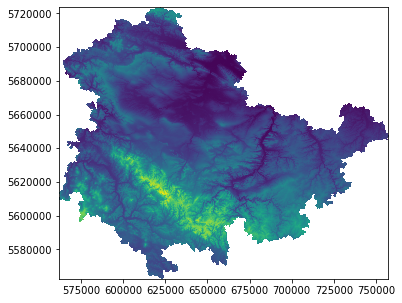

In [77]:

raster_path=r"DTM Germany_Thüringen, 20m, by Sonny\DTM Germany_Thüringen 20m.tif"

dataset = rasterio.open(raster_path)
dataset.crs

plt.figure(figsize=(8,5))
show(dataset)

### lade OSM-Data: Sportplätze in Thüringen (leisure=pitch)
* https://download.geofabrik.de/europe/germany.html

In [2]:
import os

#convert from pbf to o5m
os.system('osmconvert64-0.8.8p thueringen-latest.osm.pbf -o=thueringen.o5m')

0

In [3]:
#filter spoties
os.system('osmfilter thueringen.o5m --keep="leisure=pitch" -o=sporties.osm')

0

In [12]:
import ogr2ogr

#ogr2ogr -skipfailures -f "ESRI Shapefile" streets_shapefiles streets_liechtenstein.osm
ogr2ogr.main(["-skipfailures","-f", "ESRI Shapefile", "sportis", "sporties.osm"])

Terminating translation prematurely after failed
translation of layer other_relations (use -skipfailures to skip errors)


False

---

In [55]:
sporti=gpd.read_file('sportis/multipolygons.shp')

sporti= sporti[sporti.sport=='soccer'].copy()
sporti = sporti.to_crs("EPSG:3044")

sporti=sporti[['osm_id','geometry']].copy()
sporti["area"] = sporti['geometry'].area#/ 10**6

print (len(sporti))
sporti.head()

1593


,osm_id,geometry,area
1,2751808,"POLYGON ((735437.640 5654823.631, 735468.120 5...",7056.484575
4,2758067,"POLYGON ((730600.658 5659181.778, 730541.956 5...",7745.786171
7,2779956,"POLYGON ((741154.574 5652162.090, 741224.743 5...",7064.374416
13,2830262,"POLYGON ((736035.302 5657375.513, 736106.383 5...",3774.241803
17,2840052,"POLYGON ((733153.286 5666186.264, 733078.282 5...",13394.965007


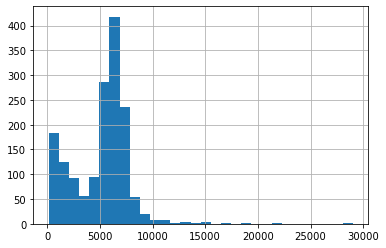

In [56]:
sporti.area.hist(bins=30)

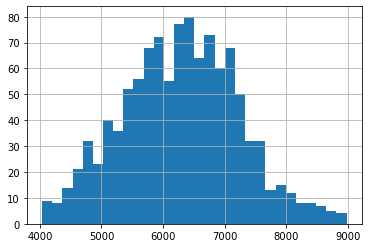

In [57]:
sporti=sporti[(sporti["area"]>4000) & (sporti["area"]<9000)].copy()
sporti.area.hist(bins=30)

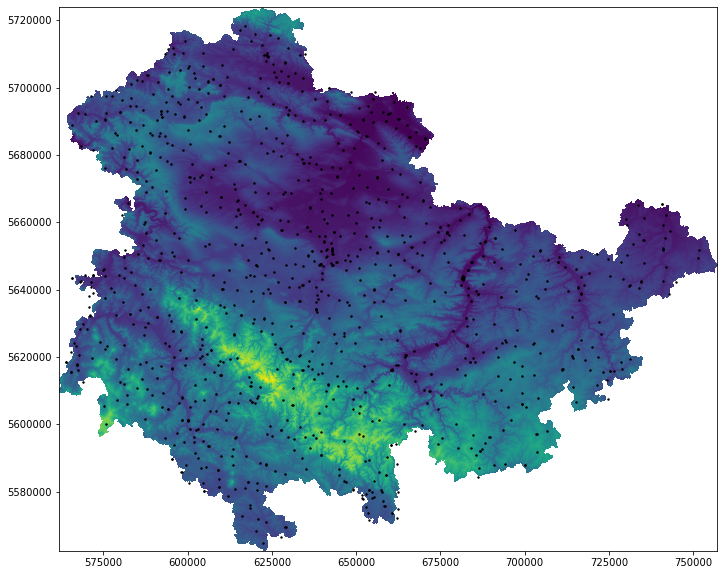

In [58]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set_aspect('equal')

show(dataset,ax=ax)
sporti.centroid.plot(ax=ax, color='black', markersize=2)

plt.show();

Sample Sportplatz


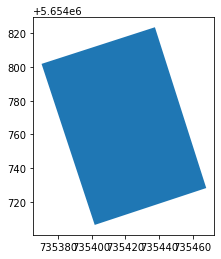

In [59]:
print ('Sample Sportplatz')
sporti[:1].plot()

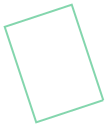

In [60]:
sporti[0:1].geometry.values[0].minimum_rotated_rectangle.exterior

In [64]:
sporti['minimum_rotated_rectangle']=sporti.geometry.apply(lambda x: list(zip(*x.minimum_rotated_rectangle.exterior.coords.xy)))
sporti.head()

,osm_id,geometry,area,minimum_rotated_rectangle
1,2751808,"POLYGON ((735437.640 5654823.631, 735468.120 5...",7056.484575,"[(735469.0699048042, 5654728.427394715), (7354..."
4,2758067,"POLYGON ((730600.658 5659181.778, 730541.956 5...",7745.786171,"[(730484.1540950644, 5659236.839875697), (7305..."
7,2779956,"POLYGON ((741154.574 5652162.090, 741224.743 5...",7064.374416,"[(741153.6526447311, 5652162.6278774105), (741..."
19,2844884,"POLYGON ((740712.833 5665538.806, 740715.826 5...",7857.228386,"[(740715.0530843562, 5665539.40460564), (74064..."
23,3508202,"POLYGON ((693380.360 5652189.889, 693433.594 5...",7481.272161,"[(693291.747832601, 5652114.013033871), (69334..."


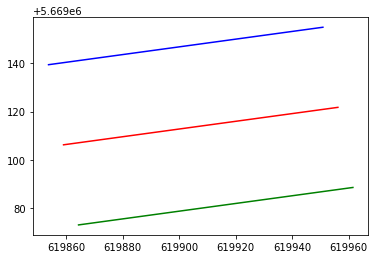

In [65]:
# extract the 2 longest lines and draw a pararlel line in between from geom

sporti['new_line_middle']=''

from shapely.geometry import Point, LineString

for index, row in sporti.iterrows():
    listee=row.minimum_rotated_rectangle
    
    dic_={}
    for e,i in enumerate(listee):

        if e>0:
            line= LineString([Point(coord), Point(i)])
            dic_[e]=[line.length,line]
        coord=i
    
    max_from_list=max([v[0]  for k, v in dic_.items()])
    #longer_lines={k: v for k, v in dic_.items() if v[0] >=max_from_list}
    longer_lines={k: v for k, v in dic_.items() if v[0] >=max_from_list-1}

    #print (max_from_list)
    #print (longer_lines)
    
    x,y   = [v[1]  for k, v in longer_lines.items()][0].coords.xy
    x2,y2 = [v[1]  for k, v in longer_lines.items()][1].coords.xy
    
    x3_right=(x2[0]+x[1])/2
    y3_right=(y2[0]+y[1])/2

    x3_left=(x2[1]+x[0])/2
    y3_left=(y2[1]+y[0])/2
    
    sporti.at[index,'new_line_middle']= LineString([Point(x3_right, y3_right), Point(x3_left,y3_left)])#.wkt #LineString ([x3_right,y3_right], [y3_left,y3_left])
    
# plot example 
plt.plot(x, y,   c='green') # Außenlinie1
plt.plot(x2, y2, c='blue') # Außenlinie2
plt.plot(np.array([x3_right,x3_left]), np.array([y3_right,y3_left]), c='red')

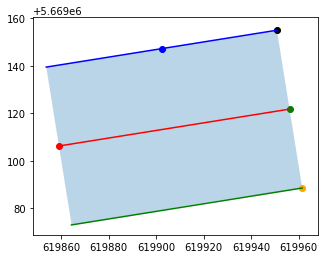

In [71]:
#Sample to understand

fig, ax = plt.subplots()

ax.set_aspect('equal')

sporti[-1:].plot(ax=ax, alpha=0.3)


x,y   = [v[1]  for k, v in longer_lines.items()][0].coords.xy
x2,y2 = [v[1]  for k, v in longer_lines.items()][1].coords.xy


x2_middle= np.array([np.mean( x2)])
y2_middle= np.array([np.mean( y2)])
plt.scatter(x2_middle,y2_middle, c='blue')


x2_right= np.array(x2[0])
y2_right= np.array(y2[0])

x_right= np.array(x[1])
y_right= np.array(y[1])

x3_right=(x2[0]+x[1])/2
y3_right=(y2[0]+y[1])/2

x3_left=(x2[1]+x[0])/2
y3_left=(y2[1]+y[0])/2


plt.plot(x, y,   c='green')
plt.plot(x2, y2, c='blue')

plt.scatter(x2_right,y2_right, c='black')
plt.scatter(x_right,y_right, c='orange')

plt.scatter(x3_right,y3_right, c='green')
plt.scatter(x3_left,y3_left, c='red')

plt.plot(np.array([x3_right,x3_left]), np.array([y3_right,y3_left]), c='red')



In [72]:
sporti.head()

,osm_id,geometry,area,minimum_rotated_rectangle,new_line_middle
1,2751808,"POLYGON ((735437.640 5654823.631, 735468.120 5...",7056.484575,"[(735469.0699048042, 5654728.427394715), (7354...",LINESTRING (735403.9176379798 5654812.96028158...
4,2758067,"POLYGON ((730600.658 5659181.778, 730541.956 5...",7745.786171,"[(730484.1540950644, 5659236.839875697), (7305...",LINESTRING (730571.4688026637 5659163.85809170...
7,2779956,"POLYGON ((741154.574 5652162.090, 741224.743 5...",7064.374416,"[(741153.6526447311, 5652162.6278774105), (741...",LINESTRING (741168.2259846015 5652059.02081461...
19,2844884,"POLYGON ((740712.833 5665538.806, 740715.826 5...",7857.228386,"[(740715.0530843562, 5665539.40460564), (74064...",LINESTRING (740690.7903617596 5665427.37756710...
23,3508202,"POLYGON ((693380.360 5652189.889, 693433.594 5...",7481.272161,"[(693291.747832601, 5652114.013033871), (69334...",LINESTRING (693406.9770014931 5652158.80456076...


1083


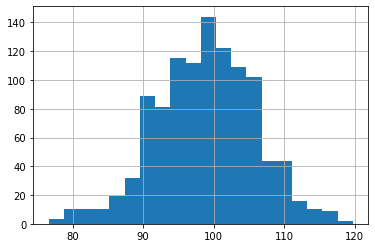

In [76]:
#from shapely.wkt import loads

sporti_line=sporti.copy()
#sporti_line['new_line_middle'] = sporti_line['new_line_middle'].apply(loads)

sporti_line = gpd.GeoDataFrame(sporti_line[['osm_id','area','new_line_middle']],
                               crs='EPSG:3044',
                                geometry='new_line_middle')

sporti_line['length']=sporti_line.new_line_middle.length
#sporti_line = sporti_line.to_crs("EPSG:3044")

sporti_line=sporti_line[sporti_line.length<120].copy()

print(len(sporti_line))
sporti_line.length.hist(bins=20)

In [80]:
from rasterstats import zonal_stats, point_query

pts_cent = point_query(sporti.centroid, raster_path)

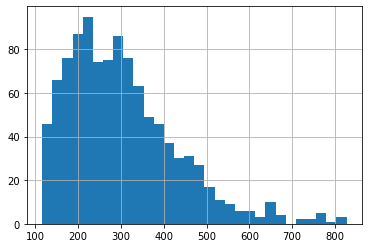

In [82]:
sporti['height_centroid']=pts_cent
sporti['height_centroid'].hist(bins=30)

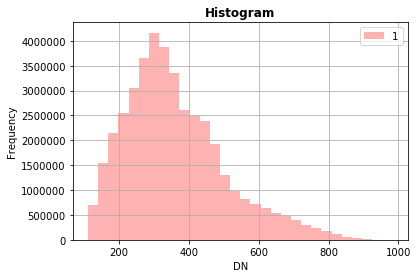

In [84]:
from rasterio.plot import show_hist
show_hist(
    dataset, bins=30, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

In [85]:
sporti.head()

,osm_id,geometry,area,minimum_rotated_rectangle,new_line_middle,height_centroid
1,2751808,"POLYGON ((735437.640 5654823.631, 735468.120 5...",7056.484575,"[(735469.0699048042, 5654728.427394715), (7354...",LINESTRING (735403.9176379798 5654812.96028158...,202.953633
4,2758067,"POLYGON ((730600.658 5659181.778, 730541.956 5...",7745.786171,"[(730484.1540950644, 5659236.839875697), (7305...",LINESTRING (730571.4688026637 5659163.85809170...,181.807922
7,2779956,"POLYGON ((741154.574 5652162.090, 741224.743 5...",7064.374416,"[(741153.6526447311, 5652162.6278774105), (741...",LINESTRING (741168.2259846015 5652059.02081461...,228.262800
19,2844884,"POLYGON ((740712.833 5665538.806, 740715.826 5...",7857.228386,"[(740715.0530843562, 5665539.40460564), (74064...",LINESTRING (740690.7903617596 5665427.37756710...,NaN
23,3508202,"POLYGON ((693380.360 5652189.889, 693433.594 5...",7481.272161,"[(693291.747832601, 5652114.013033871), (69334...",LINESTRING (693406.9770014931 5652158.80456076...,335.155650


In [134]:
sporti=sporti[sporti.height_centroid.notnull()].copy()

In [135]:
# create points every 10m to make height profile later

from shapely import wkt
from shapely.geometry import LineString

def redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))


In [136]:
#Sample

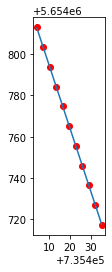

In [137]:
from shapely.geometry import Point, MultiPoint
from geopandas import GeoSeries

# E.g., every 10 m on a projected MultiLineString
multiline_r = redistribute_vertices(sporti_line.new_line_middle[1], 10)

# plot: linestring to multipoint to geoseries
gs = GeoSeries(MultiPoint(points=list(multiline_r.coords)))
ax = gs.plot( color='red', figsize=(4, 4))

# plot line
sporti_line[:1].plot(ax=ax)


In [138]:
sporti_profile=sporti_line.copy()
sporti_profile['new_line_middle']= sporti_profile.new_line_middle.apply(lambda x: redistribute_vertices(x, 10))

sporti_profile['height_profile'] = point_query(sporti_profile, raster_path)

In [205]:
sporti_profile.head()

,osm_id,area,new_line_middle,length,height_profile
1,2751808,7056.484575,"LINESTRING (735403.918 5654812.960, 735407.074...",100.696275,"[203.1000061035156, 203.10000610351562, 203.10..."
4,2758067,7745.786171,"LINESTRING (730571.469 5659163.858, 730566.338...",107.878370,"[181.86550851652672, 181.85821401330003, 181.8..."
7,2779956,7064.374416,"LINESTRING (741168.226 5652059.021, 741170.323...",98.096090,"[228.26510499495595, 228.2989115160234, 228.29..."
19,2844884,7857.228386,"LINESTRING (740690.790 5665427.378, 740689.705...",108.685091,"[None, None, None, None, None, None, None, Non..."
23,3508202,7481.272161,"LINESTRING (693406.977 5652158.805, 693399.593...",116.658854,"[336.0635743777401, 335.88427314451025, 335.70..."


In [280]:
# drop if nan
sporti_profile_nan= sporti_profile.height_profile.apply(lambda x: x[-1]).sort_values()
sporti_profile_=pd.merge(sporti_profile, sporti_profile_nan, left_index=True, right_index=True, how='left', suffixes=('','_last'))

sporti_profile_nan= sporti_profile.height_profile.apply(lambda x: x[0]).sort_values()
sporti_profile_=pd.merge(sporti_profile_, sporti_profile_nan, left_index=True, right_index=True, how='left', suffixes=('','_first'))

In [281]:
#sporti_profile_=pd.merge(sporti_profile, sporti['height_centroid'], left_index=True, right_index=True, how='left')

In [282]:
sporti_profile_=sporti_profile_[(sporti_profile_.height_profile_last.notnull())& (sporti_profile_.height_profile_first.notnull())].copy()

In [283]:
sporti_profile.height_profile[:1].values[0][-1]

202.6901183330807

In [284]:
#sporti_profile_.height_profile.apply(lambda x: x[0]).sort_values()

In [285]:
#sporti_profile_.height_profile.apply(lambda x: x[-1]).sort_values()

In [286]:
sporti_profile_

,osm_id,area,new_line_middle,length,height_profile,height_profile_last,height_profile_first
1,2751808,7056.484575,"LINESTRING (735403.918 5654812.960, 735407.074...",100.696275,"[203.1000061035156, 203.10000610351562, 203.10...",202.690118,203.100006
4,2758067,7745.786171,"LINESTRING (730571.469 5659163.858, 730566.338...",107.878370,"[181.86550851652672, 181.85821401330003, 181.8...",181.794338,181.865509
7,2779956,7064.374416,"LINESTRING (741168.226 5652059.021, 741170.323...",98.096090,"[228.26510499495595, 228.2989115160234, 228.29...",228.211515,228.265105
23,3508202,7481.272161,"LINESTRING (693406.977 5652158.805, 693399.593...",116.658854,"[336.0635743777401, 335.88427314451025, 335.70...",334.752087,336.063574
24,3609217,4981.734332,"LINESTRING (690978.373 5648298.593, 690972.839...",90.374368,"[194.0518441584255, 193.8576514678439, 193.689...",193.080239,194.051844
...,...,...,...,...,...,...,...
3394,None,5982.061734,"LINESTRING (654808.432 5612761.574, 654806.412...",101.545192,"[275.5006818855122, 275.5239119938594, 275.515...",275.718902,275.500682
3398,None,5574.385240,"LINESTRING (637744.472 5696669.989, 637734.581...",90.218996,"[210.08692623532056, 209.8572817117802, 209.83...",210.176120,210.086926
3447,None,4731.650826,"LINESTRING (614719.265 5666333.700, 614718.287...",85.984699,"[173.90000915527344, 173.90000915527344, 173.8...",173.905096,173.900009
3448,None,5947.472963,"LINESTRING (614810.440 5666472.432, 614808.902...",97.864872,"[177.93216763458648, 177.980487963318, 178.0, ...",178.130824,177.932168


In [287]:
sporti_profile_.height_profile=sporti_profile_.height_profile.apply(lambda x: x[::-1] if (x[0] > x[-1]) else x)

In [288]:
sporti_profile_

,osm_id,area,new_line_middle,length,height_profile,height_profile_last,height_profile_first
1,2751808,7056.484575,"LINESTRING (735403.918 5654812.960, 735407.074...",100.696275,"[202.6901183330807, 202.6983564146367, 202.707...",202.690118,203.100006
4,2758067,7745.786171,"LINESTRING (730571.469 5659163.858, 730566.338...",107.878370,"[181.79433781555142, 181.84777928163544, 181.8...",181.794338,181.865509
7,2779956,7064.374416,"LINESTRING (741168.226 5652059.021, 741170.323...",98.096090,"[228.21151498079828, 228.29633347464286, 228.2...",228.211515,228.265105
23,3508202,7481.272161,"LINESTRING (693406.977 5652158.805, 693399.593...",116.658854,"[334.7520873449578, 334.76368319669325, 334.81...",334.752087,336.063574
24,3609217,4981.734332,"LINESTRING (690978.373 5648298.593, 690972.839...",90.374368,"[193.08023906863485, 192.95168899795777, 192.9...",193.080239,194.051844
...,...,...,...,...,...,...,...
3394,None,5982.061734,"LINESTRING (654808.432 5612761.574, 654806.412...",101.545192,"[275.5006818855122, 275.5239119938594, 275.515...",275.718902,275.500682
3398,None,5574.385240,"LINESTRING (637744.472 5696669.989, 637734.581...",90.218996,"[210.08692623532056, 209.8572817117802, 209.83...",210.176120,210.086926
3447,None,4731.650826,"LINESTRING (614719.265 5666333.700, 614718.287...",85.984699,"[173.90000915527344, 173.90000915527344, 173.8...",173.905096,173.900009
3448,None,5947.472963,"LINESTRING (614810.440 5666472.432, 614808.902...",97.864872,"[177.93216763458648, 177.980487963318, 178.0, ...",178.130824,177.932168


In [289]:
sporti_height_profile=sporti_profile_[['height_profile']].explode('height_profile').reset_index()#.cumcount()#.transform('count')

In [290]:
sporti_height_profile

,index,height_profile
0,1,202.69
1,1,202.698
2,1,202.707
3,1,202.73
4,1,202.842
...,...,...
11218,3463,242.765
11219,3463,242.747
11220,3463,242.738
11221,3463,242.733


In [291]:
sporti_height_profile['count']=sporti_height_profile.reset_index().groupby('index').cumcount()+1

In [292]:
sporti_height_profile

,index,height_profile,count
0,1,202.69,1
1,1,202.698,2
2,1,202.707,3
3,1,202.73,4
4,1,202.842,5
...,...,...,...
11218,3463,242.765,7
11219,3463,242.747,8
11220,3463,242.738,9
11221,3463,242.733,10


In [293]:
sporti_height_profile=pd.merge(sporti_height_profile, sporti['height_centroid'], left_on='index', right_index=True, how='left')

In [294]:
sporti_height_profile['height_profile_diff']=sporti_height_profile['height_profile']-sporti_height_profile['height_centroid']

In [295]:
sporti_height_profile

,index,height_profile,count,height_centroid,height_profile_diff
0,1,202.69,1,202.953633,-0.263514
1,1,202.698,2,202.953633,-0.255276
2,1,202.707,3,202.953633,-0.246236
3,1,202.73,4,202.953633,-0.223447
4,1,202.842,5,202.953633,-0.112039
...,...,...,...,...,...
11218,3463,242.765,7,242.761812,0.00285918
11219,3463,242.747,8,242.761812,-0.0146432
11220,3463,242.738,9,242.761812,-0.0234711
11221,3463,242.733,10,242.761812,-0.0287749


In [296]:
sporti_height_profile['count_rel']=(sporti_height_profile['count']-1).div(sporti_height_profile.groupby('index')['count'].transform('count')-1, axis=0)

In [297]:
sporti_height_profile

,index,height_profile,count,height_centroid,height_profile_diff,count_rel
0,1,202.69,1,202.953633,-0.263514,0.0
1,1,202.698,2,202.953633,-0.255276,0.1
2,1,202.707,3,202.953633,-0.246236,0.2
3,1,202.73,4,202.953633,-0.223447,0.3
4,1,202.842,5,202.953633,-0.112039,0.4
...,...,...,...,...,...,...
11218,3463,242.765,7,242.761812,0.00285918,0.6
11219,3463,242.747,8,242.761812,-0.0146432,0.7
11220,3463,242.738,9,242.761812,-0.0234711,0.8
11221,3463,242.733,10,242.761812,-0.0287749,0.9


In [308]:
source

,index,height_profile,count,height_centroid,height_profile_diff,count_rel
0,1,202.69,1,202.953633,-0.263514,0.0
1,1,202.698,2,202.953633,-0.255276,0.1
2,1,202.707,3,202.953633,-0.246236,0.2
3,1,202.73,4,202.953633,-0.223447,0.3
4,1,202.842,5,202.953633,-0.112039,0.4
...,...,...,...,...,...,...
4995,1013,291.524,6,291.523814,8.5914e-06,0.5
4996,1013,291.573,7,291.523814,0.0495708,0.6
4997,1013,291.623,8,291.523814,0.0991331,0.7
4998,1013,291.682,9,291.523814,0.15854,0.8


In [321]:
import altair as alt

source=sporti_height_profile[:100]

#single_nearest = alt.selection(type='single', nearest=True, on='mouseover',
#                        fields=['x'], empty='none')
#single_nearest = alt.selection_single(on='mouseover', nearest=True)
single_nearest = alt.selection_single(on='mouseover', empty='none')

#opacity=alt.condition(single_nearest, alt.value(0.5), alt.value(0.1))

#chrt=alt.Chart(test[:5000]).mark_line(point=True, opacity=0.3).encode(
chrt=alt.Chart(source).mark_line(opacity=0.3, size=1, interpolate='step').encode(

    #x='count_rel:Q',
    x=alt.X('count_rel:Q', axis=alt.Axis(title=' ', format='%') ),
    y=alt.Y('height_profile_diff:Q', axis=alt.Axis(title='Höhenabweichnug zum Mittelpunkt') ),
    #y='height_profile_diff:Q',
    opacity=alt.condition(single_nearest, alt.value(1), alt.value(0.2)),
    size=alt.condition(single_nearest, alt.value(3), alt.value(1)),
    color=alt.Color('index:N', legend=None),
    tooltip=['index']
    #color='osm_id'
).add_selection(
    single_nearest
).properties(width=600)

chrt

alt.Chart(...)

In [335]:
import altair as alt

source=sporti_height_profile[:2000]

#single_nearest = alt.selection(type='single', nearest=True, on='mouseover',
#                        fields=['x'], empty='none')
#single_nearest = alt.selection_single(on='mouseover', nearest=True)
single_nearest = alt.selection_single(on='mouseover', empty='none')

#opacity=alt.condition(single_nearest, alt.value(0.5), alt.value(0.1))

#chrt=alt.Chart(test[:5000]).mark_line(point=True, opacity=0.3).encode(
chrt=alt.Chart(source).mark_line(opacity=0.3, size=1).encode(

    #x='count_rel:Q',
    x=alt.X('count_rel:Q', axis=alt.Axis(title=' ', format='%') ),
    y=alt.Y('height_profile_diff:Q', axis=alt.Axis(title='Höhenabweichnug zum Mittelpunkt') ),
    #y='height_profile_diff:Q',
    opacity=alt.condition(single_nearest, alt.value(1), alt.value(0.2)),
    size=alt.condition(single_nearest, alt.value(3), alt.value(1)),
    color=alt.Color('index:N', legend=None),
    #tooltip=['index'],
    #href=alt.value('www.spiegel.de')
    #color='osm_id'
).add_selection(
    single_nearest
).properties(width=600)

chrt

alt.Chart(...)

In [336]:
chrt.save('out.html')

In [324]:
sporti_profile_['height_profile_diff']=abs(sporti_profile_['height_profile_first']-sporti_profile_['height_profile_last'])

In [330]:
sporti_plot=sporti_profile_.copy()
sporti_plot.geometry=sporti_plot.centroid

In [331]:
sporti_plot

,osm_id,area,new_line_middle,length,height_profile,height_profile_last,height_profile_first,height_profile_diff
1,2751808,7056.484575,POINT (735419.701 5654765.150),100.696275,"[202.6901183330807, 202.6983564146367, 202.707...",202.690118,203.100006,0.409888
4,2758067,7745.786171,POINT (730543.248 5659209.826),107.878370,"[181.79433781555142, 181.84777928163544, 181.8...",181.794338,181.865509,0.071171
7,2779956,7064.374416,POINT (741178.712 5652106.935),98.096090,"[228.21151498079828, 228.29633347464286, 228.2...",228.211515,228.265105,0.053590
23,3508202,7481.272161,POINT (693362.671 5652120.866),116.658854,"[334.7520873449578, 334.76368319669325, 334.81...",334.752087,336.063574,1.311487
24,3609217,4981.734332,POINT (690953.469 5648336.298),90.374368,"[193.08023906863485, 192.95168899795777, 192.9...",193.080239,194.051844,0.971605
...,...,...,...,...,...,...,...,...
3394,None,5982.061734,POINT (654798.332 5612811.332),101.545192,"[275.5006818855122, 275.5239119938594, 275.515...",275.718902,275.500682,0.218220
3398,None,5574.385240,POINT (637699.965 5696677.335),90.218996,"[210.08692623532056, 209.8572817117802, 209.83...",210.176120,210.086926,0.089194
3447,None,4731.650826,POINT (614714.864 5666376.467),85.984699,"[173.90000915527344, 173.90000915527344, 173.8...",173.905096,173.900009,0.005087
3448,None,5947.472963,POINT (614802.752 5666520.757),97.864872,"[177.93216763458648, 177.980487963318, 178.0, ...",178.130824,177.932168,0.198656


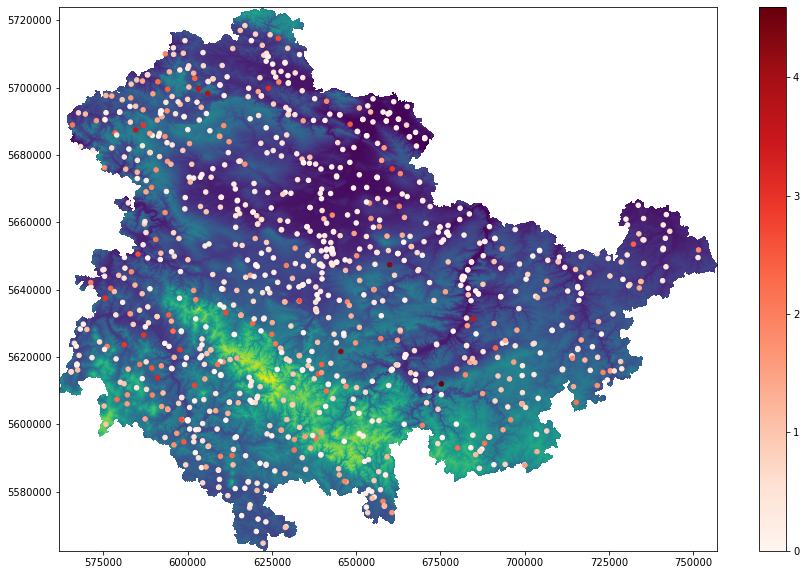

In [333]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))

ax.set_aspect('equal')

show(dataset,ax=ax)
sporti_plot=sporti_profile_.copy()
sporti_plot.geometry=sporti_plot.centroid
sporti_plot.plot(ax=ax, markersize=20, column='height_profile_diff',legend=True, cmap='Reds')

plt.show();